In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 1

In [32]:
import sys
import os 
import pandas as pd
sys.path.append('../src/detectron2/projects/DensePose')

In [298]:
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

from scipy.stats import uniform, loguniform

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from src.utils.feats import load_gei
from src.utils.plot_config import set_plot_config
from src.utils.bayes_optim import bayes_search
from src.utils.results import df_results, plot_classification_report, normalize_cfn_mtx

ImportError: cannot import name 'plot_classification_report' from 'src.utils.results' (/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/src-0.1.0-py3.8.egg/src/utils/results.py)

In [382]:
import seaborn as sns
sns.set_context('paper', font_scale=2, 
                rc={'lines.linewidth': 2,
                    'text.usetex' : True,
                    'image.interpolation': 'nearest',
                    'image.cmap': 'gray',
                    'figure.figsize': (10.0, 8.0)})
sns.set_style(style='whitegrid')
sns.set_palette('colorblind', color_codes=True)

In [322]:
# Kfold
n_splits = 3
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)  

In [6]:
dim = (64, 48)
crop_person = True

datapath = "../data/feats/database24_gei_480x640.pkl"

X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [343]:
# BE CAREFUL!!!! when loading feats y goes from 0 to 23 !
CLASSES = {
    1: 'scaffolding',
    2: 'lover',
    3: 'baby',
    4: 'appointment',
    5: 'dice',
    6: 'depression',
    7: 'elastic',
    8: 'ghost',
    9: 'impossible',
    10: 'hammer',
    11: 'miracle',
    12: 'nacionality',
    13: 'snow',
    14: 'news',
    15: 'ochestra',
    16: 'patience',
    17: 'wall',
    18: 'compsing',
    19: 'lightning',
    20: 'surf',
    21: 'television',
    22: 'trampoline',
    23: 'steam',
    24: 'fast',
} 

In [7]:
# pipeline class is used as estimator to enable
# search over different model types

base_pipe = Pipeline([   
    ('reduction', PCA()),
    ('model', SVC())
])

In [21]:
# svc_SVD = {
#     'reduction': Categorical([TruncatedSVD(random_state=0),]),
#     'reduction__n_components': Integer(60, 80),
# #     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
#     'model': Categorical([SVC()]),
#     'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
#     'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#     'model__degree': Integer(1,8),
#     'model__kernel': Categorical(['linear', 'poly', 'rbf']),
# }

svc_SVD = {
    'reduction': [TruncatedSVD(random_state=0),],
    'reduction__n_components': np.arange(60, 80, dtype=int),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': [SVC(),],
    'model__C': loguniform(1e-6, 1e+6,),
    'model__gamma': loguniform(1e-6, 1e+1),
    'model__degree': np.arange(1,8, dtype=int),
    'model__kernel': ['linear', 'poly', 'rbf'],
}

In [61]:
opt = RandomizedSearchCV(
    base_pipe,
    svc_SVD,
    n_iter=1024,
    scoring='accuracy',
    cv=cv,
)

opt = opt.fit(X,y)

In [62]:
df = pd.DataFrame(opt.cv_results_)
df.sort_values(by='rank_test_score', inplace=True, ignore_index=True)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,param_model__kernel,param_reduction,param_reduction__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070220,0.002265,0.009592,0.000417,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",341894,1,0.000483146,rbf,"TruncatedSVD(n_components=77, random_state=0)",77,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.890710,0.879121,0.873626,0.881153,0.007121,1
1,0.066475,0.003961,0.007965,0.000425,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",240710,6,0.0231956,linear,"TruncatedSVD(n_components=77, random_state=0)",72,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.901639,0.862637,0.879121,0.881133,0.015986,2
2,0.060246,0.004338,0.007822,0.000482,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",32.4617,2,6.12378e-06,linear,"TruncatedSVD(n_components=77, random_state=0)",72,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.901639,0.862637,0.879121,0.881133,0.015986,2
3,0.078265,0.015495,0.008655,0.000300,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",30.5149,1,0.426184,poly,"TruncatedSVD(n_components=77, random_state=0)",72,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.901639,0.862637,0.879121,0.881133,0.015986,2
4,0.060231,0.004798,0.007505,0.000409,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",4205.03,2,7.02629e-05,linear,"TruncatedSVD(n_components=77, random_state=0)",72,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.901639,0.862637,0.879121,0.881133,0.015986,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.078582,0.001925,0.009269,0.000274,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",9.15533e-05,2,0.0016584,linear,"TruncatedSVD(n_components=77, random_state=0)",78,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.027322,0.049451,0.038462,0.038411,0.009034,634
1020,0.069549,0.002870,0.009002,0.000349,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",0.00022708,6,0.0182276,rbf,"TruncatedSVD(n_components=77, random_state=0)",66,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.027322,0.049451,0.038462,0.038411,0.009034,634
1021,0.068567,0.003464,0.008277,0.000591,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",1.09185e-06,2,2.00395e-06,poly,"TruncatedSVD(n_components=77, random_state=0)",66,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.027322,0.049451,0.038462,0.038411,0.009034,634
1022,0.061805,0.001566,0.007066,0.000248,"SVC(C=341894.32743478916, degree=1, gamma=0.00...",1.02399e-06,4,0.0244132,linear,"TruncatedSVD(n_components=77, random_state=0)",63,"{'model': SVC(C=341894.32743478916, degree=1, ...",0.027322,0.049451,0.038462,0.038411,0.009034,634


In [77]:
n_trials = 10
n_search = 512
test_size = 0.25
res_test = []
opt = dict()


score = dict()
report = dict()
cfn_mtx = dict()

for n_trial in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=n_trial)
    
    opt[f'trial_{n_trial}'] = RandomizedSearchCV(
            base_pipe,
            svc_SVD,
            n_iter=n_search,
            scoring='accuracy',
            cv=cv,
            ).fit(X_train, y_train)
    
    res_trial = opt[f'trial_{n_trial}'].score(X_test, y_test)
    res_test.append(res_trial)
    
    
    y_pred = opt[f'trial_{n_trial}'].predict(X_test)
    score[f'trial_{n_trial}'] = opt[f'trial_{n_trial}'].score(X_test, y_test)
   
    report[f'trial_{n_trial}'] = classification_report(y_test, y_pred, labels=np.unique(y_test), zero_division=0)
    cfn_mtx[f'trial_{n_trial}'] = confusion_matrix(y_test, y_pred)

    print(f'Trial {n_trial} ACC: {res_trial}')      

print(f"Mean acc: {np.mean(res_test):.5f} +/- {np.std(res_test):.5f}\n\n")
    

Trial 0 ACC: 0.8540145985401459
Trial 1 ACC: 0.8540145985401459
Trial 2 ACC: 0.8613138686131386
Trial 3 ACC: 0.8978102189781022
Trial 4 ACC: 0.8467153284671532
Trial 5 ACC: 0.8832116788321168
Trial 6 ACC: 0.8321167883211679
Trial 7 ACC: 0.8394160583941606
Trial 8 ACC: 0.8686131386861314
Trial 9 ACC: 0.9124087591240876
Mean acc: 0.86496 +/- 0.02448




In [350]:
CLASSES.values()

dict_values(['scaffolding', 'lover', 'baby', 'appointment', 'dice', 'depression', 'elastic', 'ghost', 'impossible', 'hammer', 'miracle', 'nacionality', 'snow', 'news', 'ochestra', 'patience', 'wall', 'compsing', 'lightning', 'surf', 'television', 'trampoline', 'steam', 'fast'])

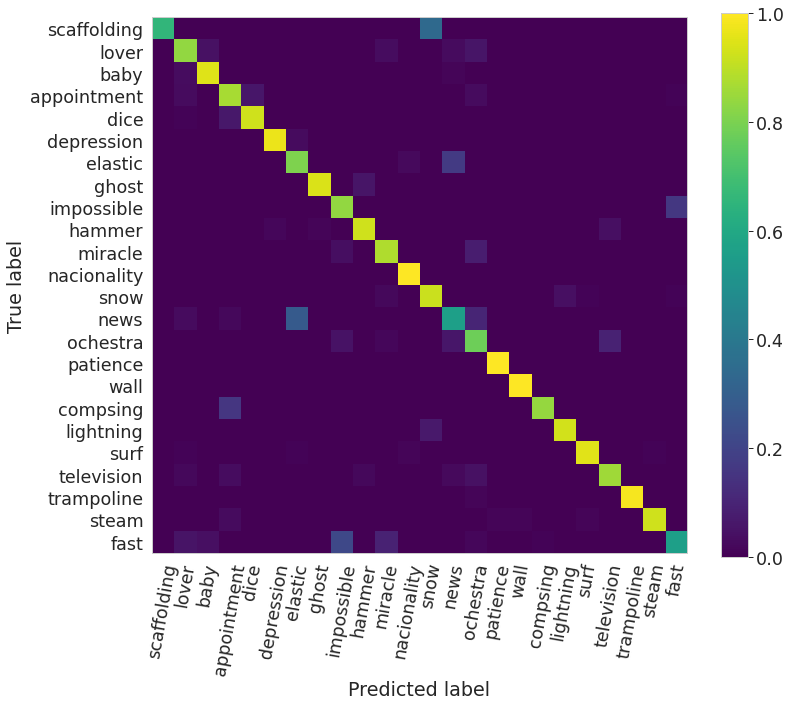

In [374]:
# mean over all trials
cfn_mean = np.zeros_like(cfn_mtx[f'trial_{0}'],dtype=float)
sum_acc = 0

all_diags = []

for n_trial in range(n_trials):
    nrmzd_cfn = normalize_cfn_mtx(cfn_mtx[f'trial_{n_trial}'], by='true')
    
    all_diags.append(nrmzd_cfn.diagonal())
    
    cfn_mean += nrmzd_cfn          
cfn_mean = cfn_mean/n_trials

fig, ax = plt.subplots(figsize=(12,10))
ax.grid(False)
disp = ConfusionMatrixDisplay(cfn_mean, display_labels=CLASSES.values())
disp.plot(include_values=False, cmap='viridis', ax=ax, xticks_rotation=80)
plt.show()

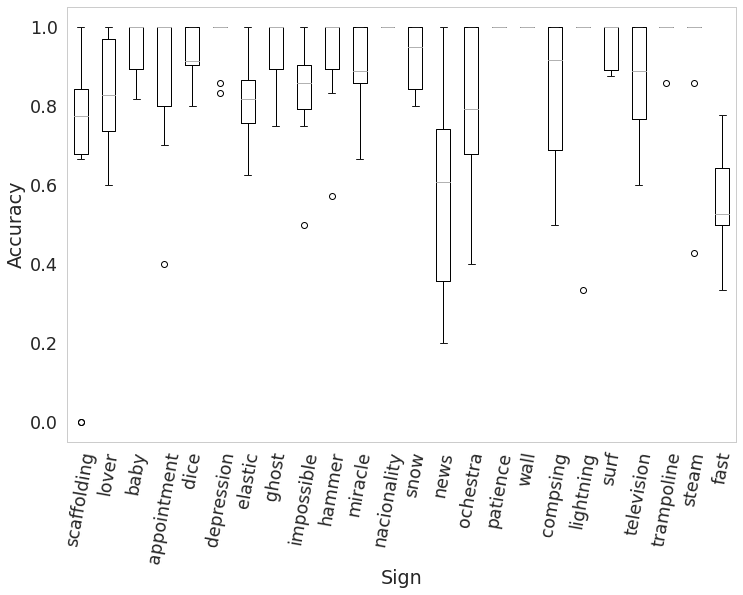

In [393]:
df = pd.DataFrame(all_diags, columns=CLASSES.values())
plt.figure(figsize=(12,8))
df.boxplot(grid=False, )
plt.ylabel('Accuracy')
plt.xticks(rotation=80, )
plt.xlabel('Sign')

ax = plt.gca()

plt.show()

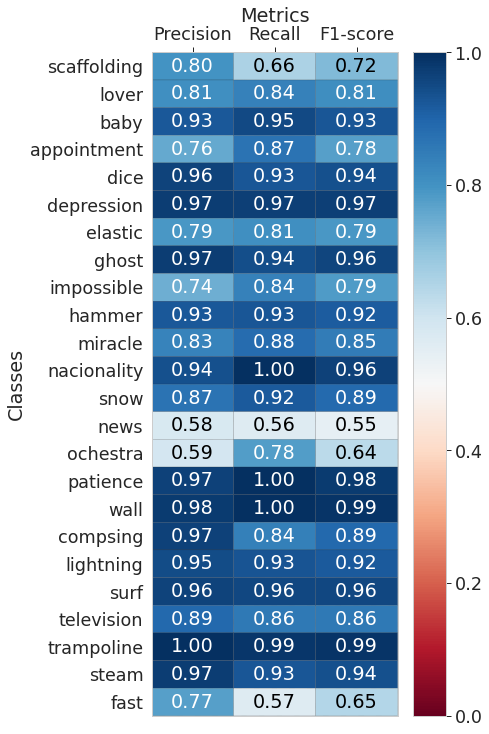

In [395]:
classes, Mat, support, class_names = read_classification_report(report[f'trial_{0}'])
Mat_mean, Mat_std = mean_classification_report(report)

plot_classification_report(
    {'classes': classes,
     'plotMat': Mat_mean,
     'support': support,
     'class_names': list(CLASSES.values()),}, figure_width=14, title='', correct_orientation=True)

In [271]:
def mean_classification_report(classification_reports):
    all_cls_reports = []

    for key, cls_report in classification_reports.items():
        classes, Mat, support, class_names = read_classification_report(classification_reports[key])
        all_cls_reports.append(Mat)

    Mat_mean = np.mean(all_cls_reports, axis=0)
    Mat_std = np.std(all_cls_reports, axis=0)

    return Mat_mean, Mat_std

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''

    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i / inch for i in tupl[0])
    else:
        return tuple(i / inch for i in tupl)


def heatmap(AUC,
            title,
            xlabel,
            ylabel,
            xticklabels,
            yticklabels,
            figure_width=40,
            figure_height=20,
            correct_orientation=False,
            cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim((0, AUC.shape[1]))

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        #         t.tick1On = False
        #         t.tick2On = False
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        #         t.tick1On = False
        #         t.tick2On = False
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))


def plot_classification_report(classification_report,
                               title='Classification report',
                               cmap='RdBu',
                               figure_width=25,
                               correct_orientation=False,
                               quiet=True):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    # lines = classification_report.split('\n')

    # classes = []
    # plotMat = []
    # support = []
    # class_names = []
    # for line in lines[2:(len(lines) - 4)]:
    #     t = line.strip().split()
    #     if len(t) < 2: continue
    #     classes.append(t[0])
    #     v = [float(x) for x in t[1:len(t) - 1]]
    #     support.append(int(t[-1]))
    #     class_names.append(t[0])

    #     if not quiet:
    #         print(v)

    #     plotMat.append(v)

    if isinstance(classification_report, str):
        classes, plotMat, support, class_names = read_classification_report(classification_report,
                                                                            quiet=quiet)
    elif isinstance(classification_report, dict):
        classes = classification_report['classes']
        plotMat = classification_report['plotMat']
        support = classification_report['support']
        class_names = classification_report['class_names']

    else:
        ValueError(f'classification_report must be `str` or `dict`: {type(classification_report)}')

    if not quiet:
        print('plotMat: {0}'.format(plotMat))
        print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    #     yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    yticklabels = ['{0}'.format(class_names[idx]) for idx, _ in enumerate(support)]
    #     figure_width = 25
    figure_height = len(class_names) + 7
    #     correct_orientation = False
    heatmap(np.array(plotMat),
            title,
            xlabel,
            ylabel,
            xticklabels,
            yticklabels,
            figure_width,
            figure_height,
            correct_orientation,
            cmap=cmap)


def read_classification_report(classification_report, quiet=True):
    lines = classification_report.split('\n')

    classes = []
    Mat = []
    support = []
    class_names = []
    for line in lines[2:(len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1:len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])

        if not quiet:
            print(v)

        Mat.append(v)

    return classes, Mat, support, class_names